# Binary Classification

In [29]:
from sklearn.datasets import fetch_openml
>>> mnist = fetch_openml('mnist_784', version=1)

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [30]:
X, y = mnist["data"], mnist["target"]
X.shape
y.shape

(70000,)

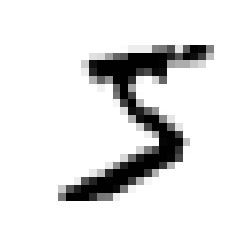

In [34]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")


plt.show()

In [35]:
y[0]

'5'

In [37]:
y = y.astype(np.uint8)

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns

In [38]:
y[0]

5

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [39]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [40]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Stochastic Gradient
Descent (SGD) classifier, using Scikit-Learn’s SGDClassifier classThis classifier
has the advantage of being capable of handling very large datasets efficiently. This is
in part because SGD deals with training instances independently, one at a time
(which also makes SGD well suited for online learning)

In [41]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
sgd_clf.predict([some_digit])

array([ True])

In [43]:
sgd_clf.predict([X[100]])

array([ True])

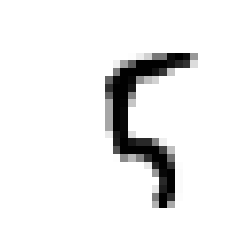

In [44]:
some_digit = X[100]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [45]:
y[100]

5

## Measuring Accuracy Using Cross-Validation

The StratifiedKFold class performs stratified sampling 
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions

In [46]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96355
0.93795
0.95615


In [47]:
>>> from sklearn.model_selection import cross_val_score
>>> cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.96355, 0.93795, 0.95615])

accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others).

## Confusion Matrix

To compute the confusion matrix, you first need to have a set of predictions so that
they can be compared to the actual targets

Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions
made on each test fold. This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

In [48]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [50]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [49]:
from sklearn.metrics import confusion_matrix
>>> confusion_matrix(y_train_5, y_train_pred)

array([[53057,  1522],
       [ 1325,  4096]], dtype=int64)

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diagonal
(top left to bottom right)

## Precision and Recall

In [51]:
>>> from sklearn.metrics import precision_score, recall_score
>>> precision_score(y_train_5, y_train_pred)

0.7290850836596654

In [52]:
recall_score(y_train_5, y_train_pred)

0.7555801512636044

When it claims an image represents a 5, it is correct only 72.9% of the time. Moreover,
it only detects 75.6% of the 5s.

The F1 score is
the harmonic mean of precision and recall . Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are
high

In [53]:
from sklearn.metrics import f1_score
>>> f1_score(y_train_5, y_train_pred)

0.7420962043663375

###  Precision/Recall Trade-off

For each instance, it computes a score based on a decision function. If
that score is greater than a threshold, it assigns the instance to the positive class;
otherwise it assigns it to the negative class

In [54]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([283.84285103])

In [55]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)


In [56]:
y_some_digit_pred

array([ True])

In [57]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall.

How do you decide which threshold to use? First, use the cross_val_predict()
function to get the scores of all instances in the training set, but this time specify that
you want to return decision scores instead of predictions.

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds.

Finally, use Matplotlib to plot precision and recall as functions of the threshold value

In [58]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [59]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

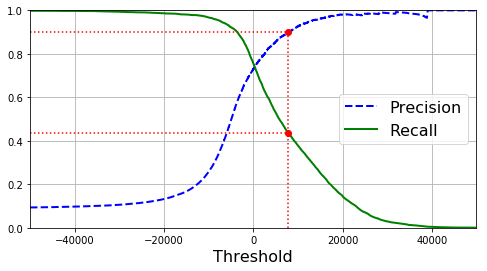

In [61]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)       
    plt.grid(True)                              
    plt.axis([-50000, 50000, 0, 1])            



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                         # Not shown
plt.show()

In [62]:
(y_train_pred == (y_scores > 0)).all()

True

Another way to select a good precision/recall trade-off is to plot precision directly
against recall

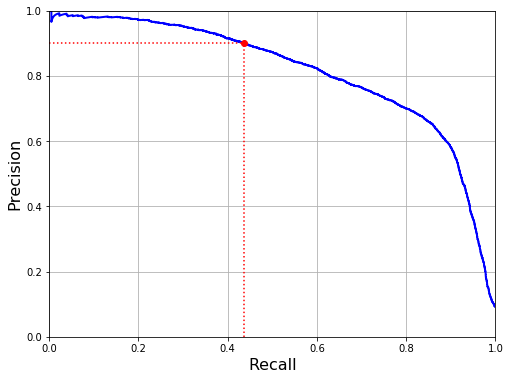

In [63]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

You can see that precision really starts to fall sharply around 80% recall. You will
probably want to select a precision/recall trade-off just before that drop—for example,
at around 60% recall.

Suppose you decide to aim for 90% precision. You look up the first plot and find that
you need to use a threshold of about 8,000. To be more precise you can search for the
lowest threshold that gives you at least 90% precision (np.argmax() will give you the
first index of the maximum value, which in this case means the first True value):

In [64]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

7816.1555236825225

To make predictions (on the training set for now), instead of calling the classifier’s
predict() method, you can run this code

In [65]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [66]:
precision_score(y_train_5, y_train_pred_90)

0.9000380083618396

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.4368197749492714

high-precision classifier is not very useful if its
recall is too low!If someone says, “Let’s reach 99% precision,” you should ask, “At
what recall?”

## The ROC Curve

It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate (FPR). The FPR is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true negative rate
(TNR), which is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [68]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

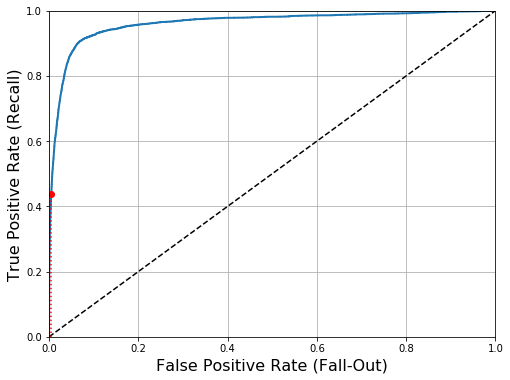

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro")


Once again there is a trade-off: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5

In [70]:
>>> from sklearn.metrics import roc_auc_score
>>> roc_auc_score(y_train_5, y_scores)

0.9611778893101814

#### Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule
of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve.

In [71]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba") 
#the Random ForestClassifier class does not have a decision_function() method. Instead, it has a predict_proba() method.

In [72]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

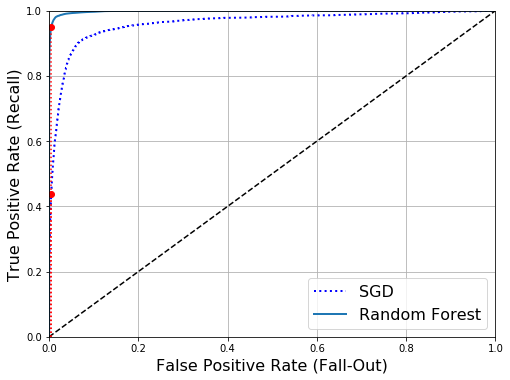

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [74]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also
called multinomial classifiers) can distinguish between more than two classes

Some algorithms (such as SGD classifiers, Random Forest classifiers, and naive Bayes
classifiers) are capable of handling multiple classes natively. Others (such as Logistic
Regression or Support Vector Machine classifiers) are strictly binary classifiers.

there are various strategies that you can use to perform multiclass classification
with multiple binary classifiers.

1.one-versus-the-rest (OvR) strategy (also called
one-versus-all).

2.one-versus-one (OvO) strategy

The main advantage
of OvO is that each classifier only needs to be trained on the part of the training
set for the two classes that it must distinguish.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the
size of the training set. For these algorithms OvO is preferred because it is faster to
train many classifiers on small training sets than to train few classifiers on large training
sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvR or OvO, depending on the
algorithm.

In [75]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [76]:
>>> some_digit_scores = svm_clf.decision_function([some_digit])
>>> some_digit_scores

array([[ 2.92493762,  7.02307135,  3.93649283,  0.90118537,  5.96946271,
         9.5       ,  1.90719696,  8.02754761, -0.13207079,  4.94217633]])

Scikit-Learn actually used the OvO strategy: it trained 45 binary classifiers, got their
decision scores for the image, and selected the class that won the most duels.
If you call the decision_function() method, you will see that it returns 10 scores
per instance (instead of just 1). That’s one score per class

In [77]:
>>> np.argmax(some_digit_scores)

5

When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value.

In [78]:
>>> svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [79]:
>>> svm_clf.classes_[5]

5

To use OVR or OVO explicitly unlike in previouscase where scikit choose automatically

In [80]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [81]:
len(ovr_clf.estimators_)

10

In [82]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9], dtype=uint8)

This time Scikit-Learn did not have to run OvR or OvO because SGD classifiers can
directly classify instances into multiple classes. The decision_function() method
now returns one value per class.

In [83]:
sgd_clf.decision_function([some_digit])

array([[-18461.78599452, -22077.69350459,  -7990.83826999,
         -6351.24712557,  -2181.02436288,    283.84285103,
        -13005.73873212,  -9434.43887713,  -3125.37819061,
          4050.73201305]])

In [84]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8489802 , 0.87129356, 0.86988048])

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89707059, 0.8960948 , 0.90693604])

# Error Analysis

In [86]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
>>> conf_mx = confusion_matrix(y_train, y_train_pred)
>>> conf_mx

array([[5578,    0,   22,    7,    8,   45,   35,    5,  222,    1],
       [   0, 6410,   35,   26,    4,   44,    4,    8,  198,   13],
       [  28,   27, 5232,  100,   74,   27,   68,   37,  354,   11],
       [  23,   18,  115, 5254,    2,  209,   26,   38,  373,   73],
       [  11,   14,   45,   12, 5219,   11,   33,   26,  299,  172],
       [  26,   16,   31,  173,   54, 4484,   76,   14,  482,   65],
       [  31,   17,   45,    2,   42,   98, 5556,    3,  123,    1],
       [  20,   10,   53,   27,   50,   13,    3, 5696,  173,  220],
       [  17,   64,   47,   91,    3,  125,   24,   11, 5421,   48],
       [  24,   18,   29,   67,  116,   39,    1,  174,  329, 5152]],
      dtype=int64)

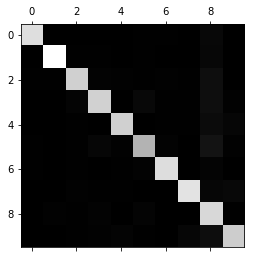

In [87]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [88]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

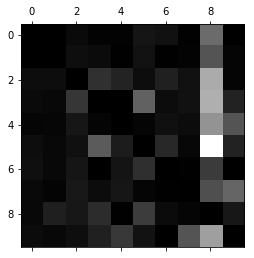

In [89]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [92]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

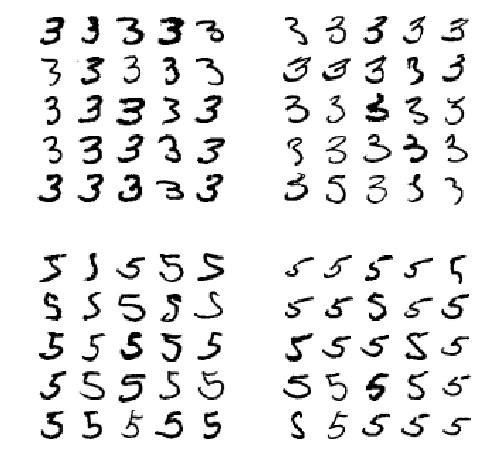

In [93]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# MultiLabel

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance.a classification system that outputs multiple binary tags is
called a multilabel classification system.

## Multiclass classification:
classification task with more than two classes. Each sample can only be labelled as one class.

## Multilabel classification:
classification task labelling each sample with x labels from n_classes possible classes, where x can be 0 to n_classes inclusive. This can be thought of as predicting properties of a sample that are not mutually exclusive. Formally, a binary output is assigned to each class, for every sample. Positive classes are indicated with 1 and negative classes with 0 or -1. It is thus comparable to running n_classes binary classification tasks .

## Multioutput regression: 
predicts multiple numerical properties for each sample. Each property is a numerical variable and the number of properties to be predicted for each sample is greater than or equal to 2 .

## Multioutput-multiclass classification (also known as multitask classification):
classification task which labels each sample with a set of non-binary properties. Both the number of properties and the number of classes per property is greater than 2.

It is simply a generalization
of multilabel classification where each label can be multiclass (i.e., it can have
more than two possible values).


In [94]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


In [ ]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")